<a href="https://colab.research.google.com/github/5ury4pr454th/building-scene-classification/blob/main/Test_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nvidia-cublas-cu12==12.1.3.1 \
            nvidia-cuda-cupti-cu12==12.1.105 \
            nvidia-cuda-nvrtc-cu12==12.1.105 \
            nvidia-cuda-runtime-cu12==12.1.105 \
            nvidia-cudnn-cu12==8.9.2.26 \
            nvidia-cufft-cu12==11.0.2.54 \
            nvidia-curand-cu12==10.3.2.106 \
            nvidia-cusolver-cu12==11.4.5.107 \
            nvidia-cusparse-cu12==12.1.0.106 \
            nvidia-nvtx-cu12==12.1.105 \
            nvidia-nccl-cu12==2.20.5

  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux20

In [ ]:
!pip install xgboost

In [2]:
#@title
# for basic file navigation and driving mount
import os
from google.colab import drive

# some basic libraries
import xgboost
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# importing for basic image operations
import cv2 as cv
from PIL import Image
from PIL import ImageOps
import seaborn as sns
import pandas as pd

# data structures
from collections import OrderedDict

# importing pretrained models
from tensorflow.keras.applications import efficientnet

# for splitting data
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# prerequisites for training models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# for selecting better metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# initialize TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)  # Atualização aqui
except:
    strategy = tf.distribute.get_strategy()

print(f"Strategy: {strategy}")


drive.mount('/content/gdrive')

Strategy: <tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x7b4547c663e0>
Mounted at /content/gdrive


In [8]:
# variables to change

TRAIN_IMG_DIR_PATH = "/content/gdrive/MyDrive/Colab Notebooks/TCC/Scripts/imagens_bd/results_train"
TEST_IMG_DIR_PATH = "/content/gdrive/MyDrive/Colab Notebooks/TCC/Scripts/imagens_bd/results_test/"
TRAIN_SC_DIR_PATH = "/content/gdrive/MyDrive/Colab Notebooks/TCC/Scripts/indian-street-scenes/train-resized"
TEST_SC_DIR_PATH = "/content/gdrive/MyDrive/Colab Notebooks/TCC/Scripts/indian-street-scenes/test-resized"
model_path = "/content/gdrive/MyDrive/Colab Notebooks/TCC/Scripts/modelo"
#classes = ["residential", "mixed", "commercial","others","industrial"]
classes = ["residential", "commercial","others","industrial"]

INPUT_IMG_WIDTH = 250
INPUT_IMG_HEIGHT = 350
VERTICAL = True

In [4]:
new_eff_model = tf.keras.models.load_model(model_path + '/' + 'modelo_att(10e).keras')

In [5]:
new_eff_model.load_weights(model_path + '/' + 'modelo_att.weights.h5')

In [9]:
#@title
target_class = "residential"
residential_prediction_mapping = OrderedDict()

with strategy.scope():

  for file_name in os.listdir(TEST_IMG_DIR_PATH + target_class):

    img = Image.open(TEST_IMG_DIR_PATH + target_class + '/'+ file_name)
    building_image = np.array(ImageOps.fit(img,(250, 350), Image.LANCZOS))
    building_image = np.expand_dims(building_image, axis = 0)
    residential_prediction_mapping[target_class + '/'+ file_name] = new_eff_model.predict(building_image)

target_class = "commercial"
commercial_prediction_mapping = OrderedDict()
with strategy.scope():

  for file_name in os.listdir(TEST_IMG_DIR_PATH + target_class):
    img = Image.open(TEST_IMG_DIR_PATH + target_class + '/'+ file_name)
    building_image = np.array(ImageOps.fit(img,(250, 350), Image.LANCZOS))
    building_image = np.expand_dims(building_image, axis = 0)
    commercial_prediction_mapping[target_class + '/'+ file_name] = new_eff_model.predict(building_image)

target_class = "industrial"
industrial_prediction_mapping = OrderedDict()
with strategy.scope():

  for file_name in os.listdir(TEST_IMG_DIR_PATH + target_class):
    img = Image.open(TEST_IMG_DIR_PATH + target_class + '/'+ file_name)
    building_image = np.array(ImageOps.fit(img,(250, 350), Image.LANCZOS))
    building_image = np.expand_dims(building_image, axis = 0)
    industrial_prediction_mapping[target_class + '/'+ file_name] = new_eff_model.predict(building_image)

target_class = "others"
others_prediction_mapping = OrderedDict()
with strategy.scope():

  for file_name in os.listdir(TEST_IMG_DIR_PATH + target_class):

    img = Image.open(TEST_IMG_DIR_PATH + target_class + '/'+ file_name)
    building_image = np.array(ImageOps.fit(img,(250, 350), Image.LANCZOS))
    building_image = np.expand_dims(building_image, axis = 0)
    others_prediction_mapping[file_name] = new_eff_model.predict(building_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/

In [10]:
#@title
others_predictions = OrderedDict()

for file_name in others_prediction_mapping.keys():
  # others_predictions[file_name] = np.argmax(others_prediction_mapping[file_name], axis = 1)[0]
  others_predictions[file_name] = others_prediction_mapping[file_name]

others_scene_predictions = OrderedDict()
for file_name in others_predictions.keys():
  scene_file_name = '_'.join(os.path.splitext(file_name)[0].split('_')[-3:]) + os.path.splitext(file_name)[1]
  if scene_file_name not in others_scene_predictions.keys():
    others_scene_predictions[scene_file_name] = [others_predictions[file_name]]
  else:
    others_scene_predictions[scene_file_name].append(others_predictions[file_name])

residential_predictions = OrderedDict()
for file_name in residential_prediction_mapping.keys():
  # residential_predictions[file_name] = np.argmax(residential_prediction_mapping[file_name], axis = 1)[0]

  residential_predictions[file_name] = residential_prediction_mapping[file_name]

residential_scene_predictions = OrderedDict()
for file_name in residential_predictions.keys():
  scene_file_name = '_'.join(os.path.splitext(file_name)[0].split('_')[-3:]) + os.path.splitext(file_name)[1]
  if scene_file_name not in residential_scene_predictions.keys():
    residential_scene_predictions[scene_file_name] = [residential_predictions[file_name]]
  else:
    residential_scene_predictions[scene_file_name].append(residential_predictions[file_name])

commercial_predictions = OrderedDict()
for file_name in commercial_prediction_mapping.keys():
  # commercial_predictions[file_name] = np.argmax(commercial_prediction_mapping[file_name], axis = 1)[0]

  commercial_predictions[file_name] = commercial_prediction_mapping[file_name]
commercial_scene_predictions = OrderedDict()
for file_name in commercial_predictions.keys():
  scene_file_name = '_'.join(os.path.splitext(file_name)[0].split('_')[-3:]) + os.path.splitext(file_name)[1]
  if scene_file_name not in commercial_scene_predictions.keys():
    commercial_scene_predictions[scene_file_name] = [commercial_predictions[file_name]]
  else:
    commercial_scene_predictions[scene_file_name].append(commercial_predictions[file_name])

industrial_predictions = OrderedDict()
for file_name in industrial_prediction_mapping.keys():
  # industrial_predictions[file_name] = np.argmax(industrial_prediction_mapping[file_name], axis = 1)[0]

  industrial_predictions[file_name] = industrial_prediction_mapping[file_name]
industrial_scene_predictions = OrderedDict()
for file_name in industrial_predictions.keys():
  scene_file_name = '_'.join(os.path.splitext(file_name)[0].split('_')[-3:]) + os.path.splitext(file_name)[1]
  if scene_file_name not in industrial_scene_predictions.keys():
    industrial_scene_predictions[scene_file_name] = [industrial_predictions[file_name]]
  else:
    industrial_scene_predictions[scene_file_name].append(industrial_predictions[file_name])

Imprimir Previsões

 Visualizar Imagens e Previsões

In [11]:
TEST_IMG_DIR_PATH

'/content/gdrive/MyDrive/Colab Notebooks/TCC/Scripts/imagens_bd/results_test/'

Residential Images and Predictions:
residential/1_tr_r_12.png


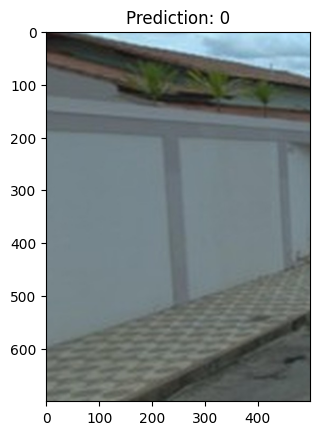

residential/2_tr_r_12.png


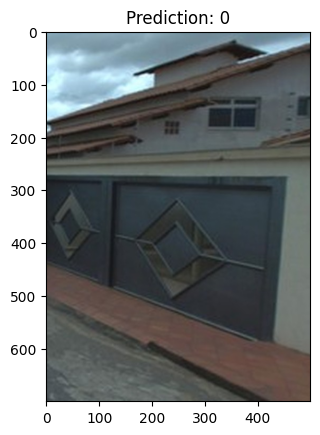

residential/6_tr_r_9.png


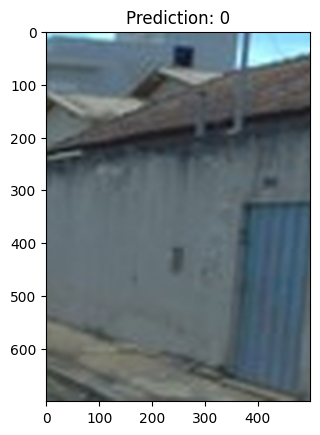

residential/4_tr_r_9.png


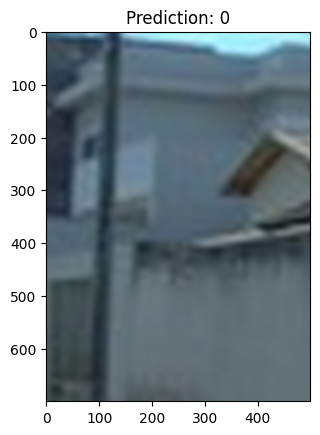

residential/3_tr_r_9.png


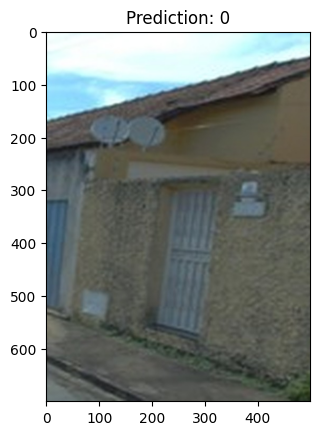

residential/9_tr_r_9.png


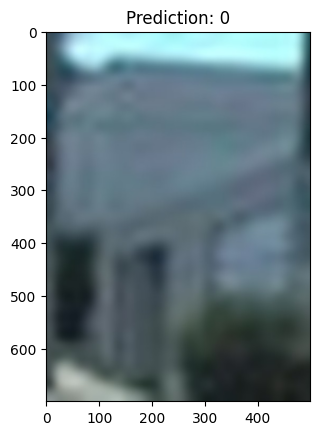

residential/8_tr_r_9.png


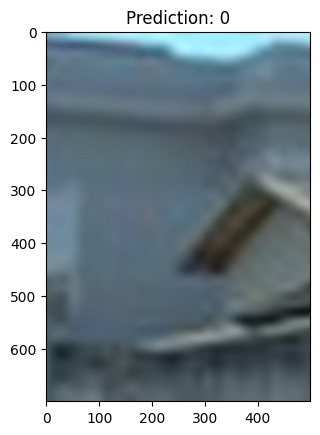

residential/7_tr_r_9.png


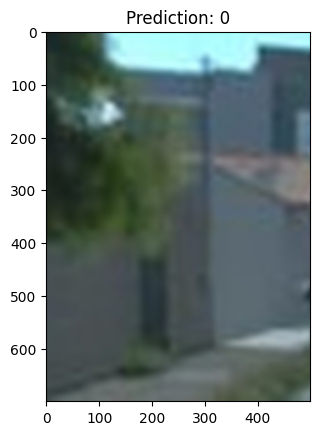

residential/10_tr_r_9.png


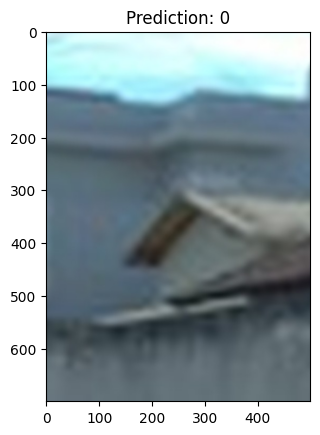

residential/11_tr_r_9.png


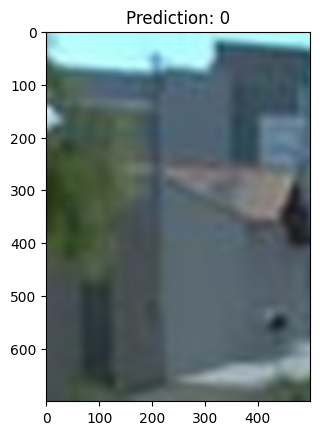

Commercial Images and Predictions:
commercial/0_tr_c_12.png


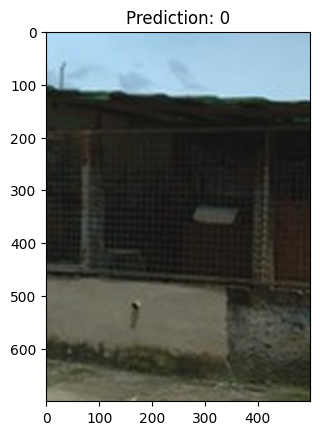

commercial/4_tr_c_12.png


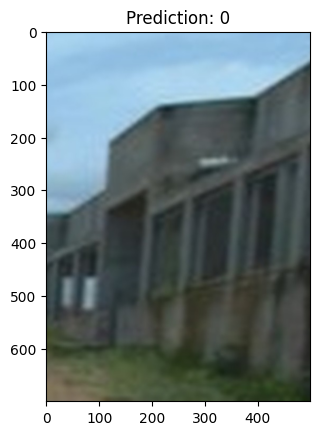

commercial/5_tr_c_13.png


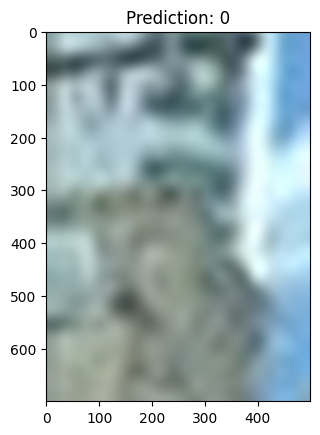

commercial/1_tr_c_13.png


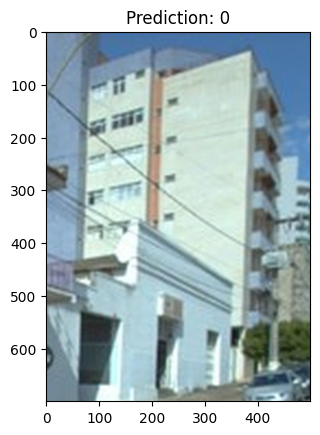

commercial/6_tr_c_13.png


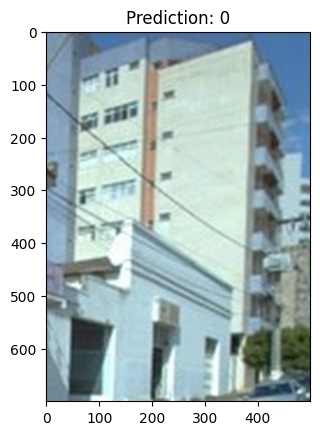

commercial/0_tr_c_13.png


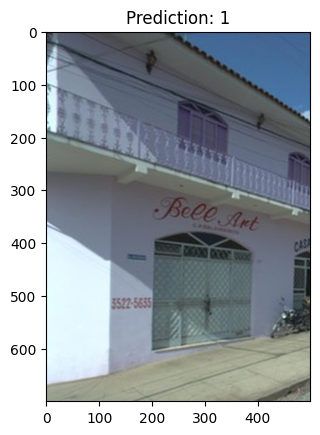

commercial/1_tr_c_9.png


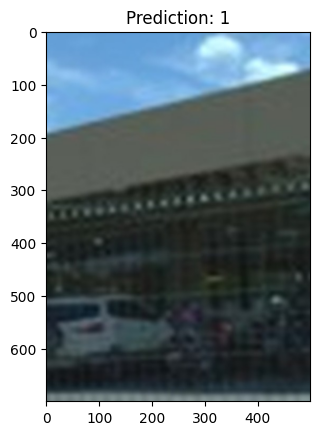

commercial/4_tr_c_8.png


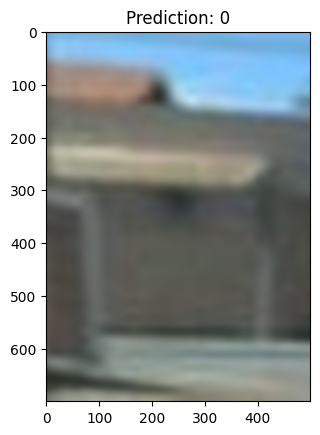

commercial/5_tr_c_8.png


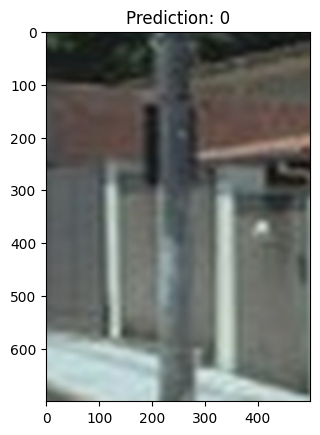

commercial/1_tr_c_8.png


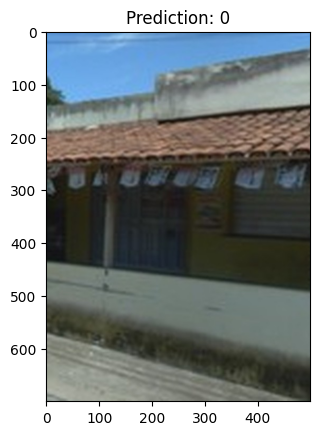

Industrial Images and Predictions:
industrial/6_tr_i_12.png


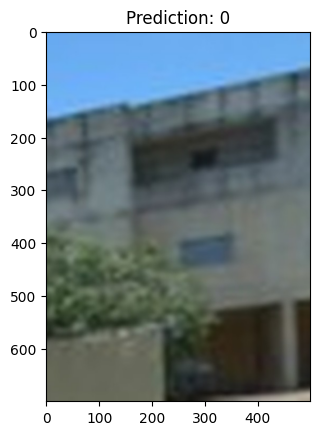

industrial/9_tr_i_12.png


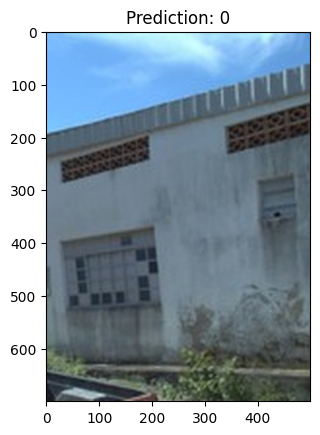

industrial/13_tr_i_12.png


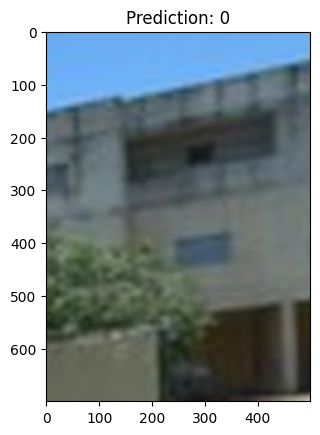

Other Images and Predictions:
2_tr_o_5.png


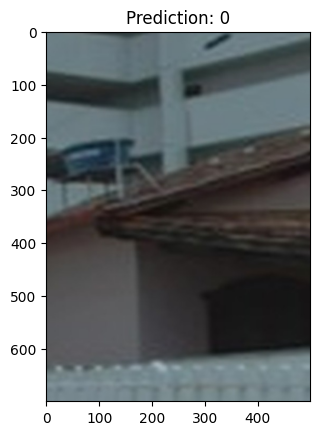

1_tr_o_5.png


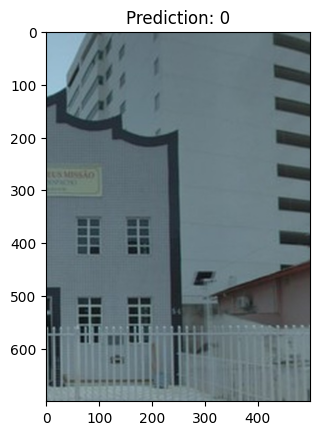

10_tr_o_5.png


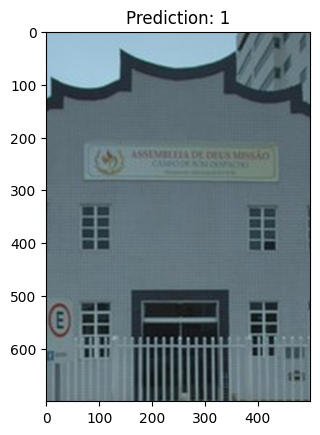

9_tr_o_5.png


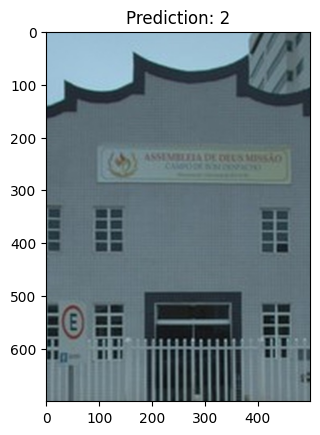

6_tr_o_6.png


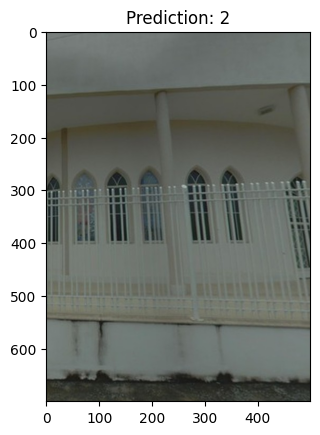

2_tr_o_6.png


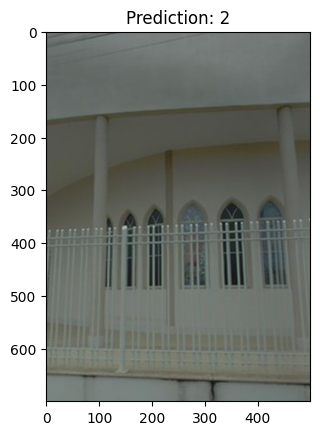

1_tr_o_6.png


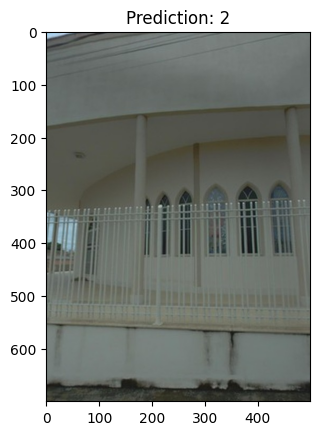

6_tr_o_7.png


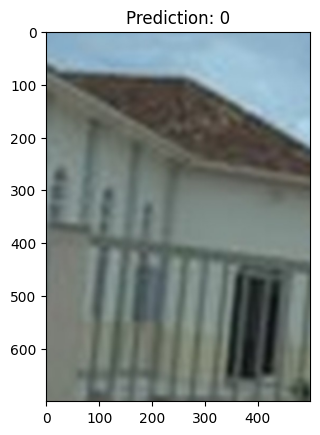

2_tr_o_7.png


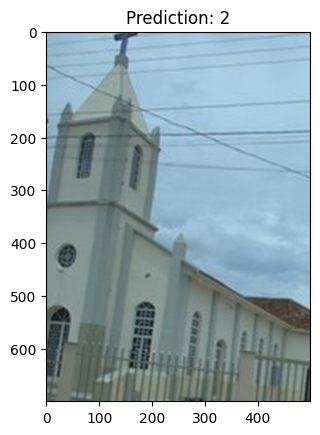

In [12]:
import matplotlib.pyplot as plt
from PIL import Image

# Function to plot a sample of the images and their predictions
def plot_sample_images(prediction_mapping, target_class, num_samples=10):
    sample_predictions = list(prediction_mapping.items())[:num_samples]
    for file_path, prediction in sample_predictions:
        # Check if the path does not start with any of the known prefixes
        print(file_path)
        if not file_path.startswith(('commercial', 'residential', 'industrial')):
            file_path = 'others/' + file_path

        img = Image.open(TEST_IMG_DIR_PATH + '/' + file_path)
        plt.imshow(img)
        plt.title(f"Prediction: {np.argmax(prediction)}")
        plt.show()


# Plot sample images and their predictions for each class
print("Residential Images and Predictions:")
plot_sample_images(residential_prediction_mapping, "residential")

print("Commercial Images and Predictions:")
plot_sample_images(commercial_prediction_mapping, "commercial")

print("Industrial Images and Predictions:")
plot_sample_images(industrial_prediction_mapping, "industrial")

print("Other Images and Predictions:")
plot_sample_images(others_prediction_mapping, "others")
